In [1]:
import numpy             as np
import matplotlib.pyplot as plt

from matplotlib          import rcParams, rc
# Change the matplotlib default parameters
# rcParams.update({'font.size':   12})
rcParams.update({'figure.dpi': 200})
# rc('font', family='serif')
# rc('text', usetex=True)

from astropy import units as units

from src.odes           import ODE
from src.rates          import initialise_abs, calculate_rates
from src.input          import setinput, getcst

from scipy.integrate    import solve_ivp
from astropy            import constants

In [2]:
## constants
kB, mH, rGr, nGr, stckH, AUV_AV = getcst()

## input values physics
ρ, T, δ, Av, chemtype = setinput()

## input chemistry
chemtype = 'C'

## calculate H accretion on dust
Haccr = stckH *np.pi*(rGr**2.0)*ρ*nGr*(8.0*kB*T/(np.pi*mH))**0.5

yr_to_sec = units.year.to('s')         ## year in seconds

Input:
------
ρ  = 1.13E+05
T  = 2500.0
δ  = 1.0
Av = 0.5

Chem type = C


In [3]:
print(yr_to_sec)

31557600.0


In [4]:
n, nconsv, specs = initialise_abs(chemtype)     # n_consv = TOTAL in fortran code
timesteps = 1

ndot        = np.zeros(len(n))
nconsvdot   = np.zeros(len(nconsv))
t           = np.zeros(timesteps)

k = calculate_rates(T, δ, Av)

In [5]:
t=0.0
# ODE(t, n, n_consv, ndot, X, k, ρ, Haccr)

In [6]:
Δt = 1.0e+2*yr_to_sec  ## in sec

Δt = 1.e+2*1.e+6

solution = solve_ivp(
    fun          = ODE,
    t_span       = [0.0, Δt],
    y0           = n,
    method       = 'BDF',   ## zoals DVODE
    args         = (ndot, nconsvdot, nconsv,k, ρ, Haccr),
    dense_output = False    ## if True: returns interpolation function
)

assert solution['status'] == 0

ys = solution['y']
ts = solution['t']

print(solution['message'])

The solver successfully reached the end of the integration interval.


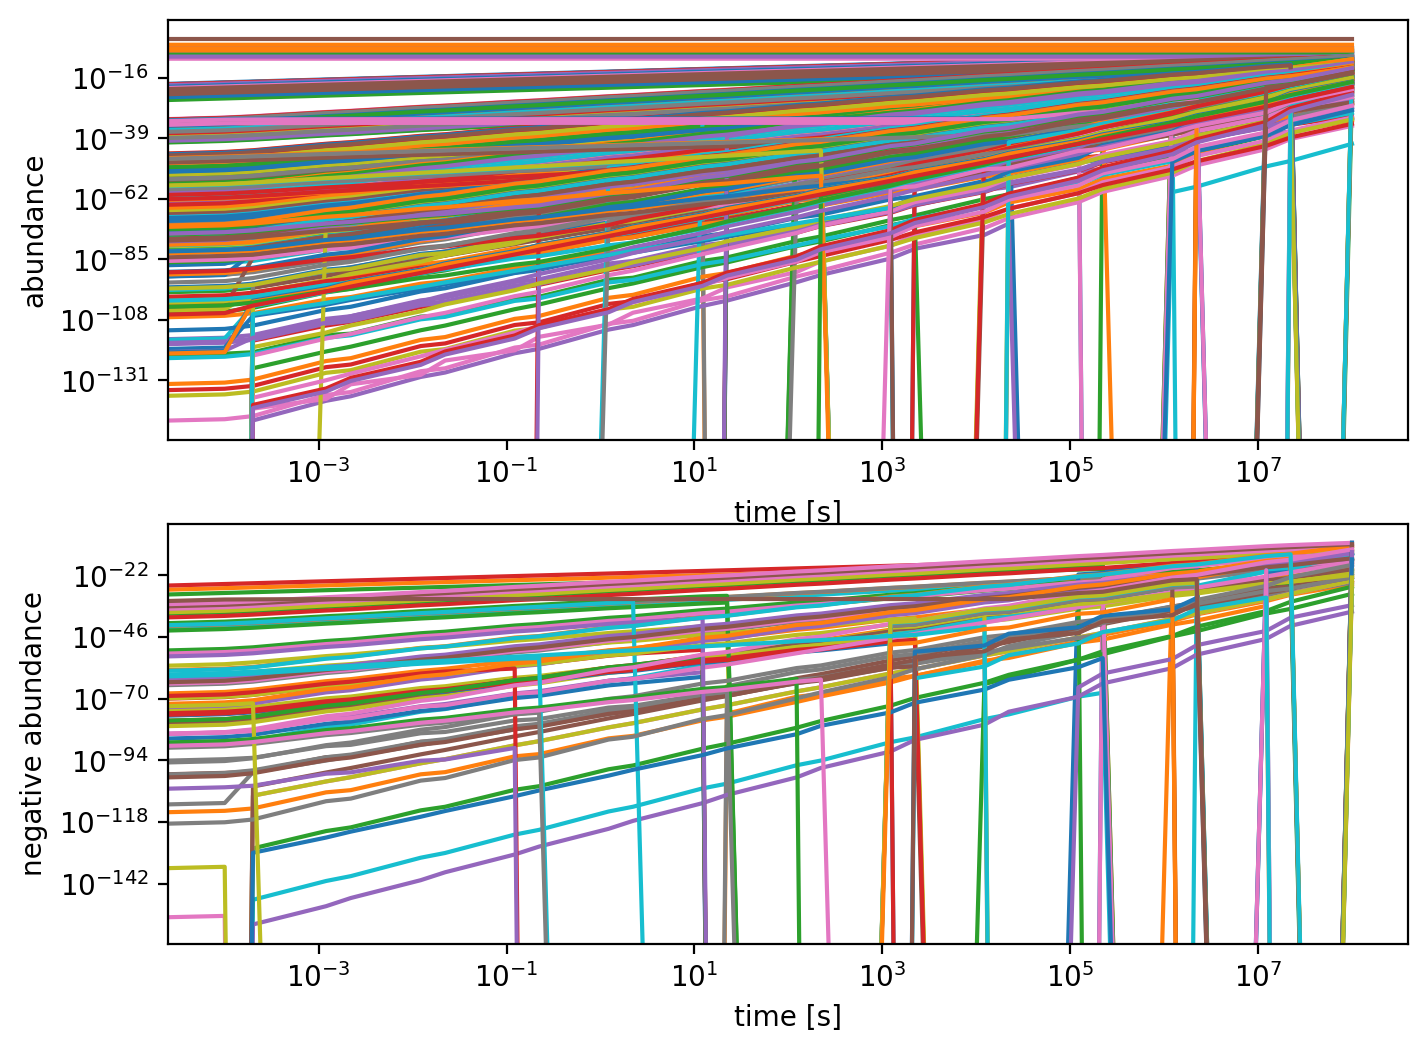

In [7]:
fig = plt.figure(figsize=(8,6))

ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
axs = [ax1,ax2]

for i in range(ys.shape[0]):
    ax1.plot(ts, ys[i])
    ax2.plot(ts, -ys[i])

for ax in axs:
    ax.set_yscale('log')
    ax.set_xscale('log')

    # ax.set_ylim((1.0e-40, 1.0e+0))

    ax.set_xlabel('time [s]')
ax1.set_ylabel('abundance')
ax2.set_ylabel('negative abundance')

plt.show()

In [8]:
ys.shape[0]

466

In [9]:
idx_neg = list()

for i in range(ys.shape[0]):
    if np.any(ys[i] < 0):
        idx_neg.append(i)

In [10]:
print(len(idx_neg),idx_neg)

122 [1, 2, 3, 7, 11, 20, 21, 29, 42, 51, 57, 82, 83, 85, 91, 92, 98, 101, 108, 109, 113, 114, 116, 117, 118, 119, 120, 121, 122, 127, 128, 136, 161, 164, 165, 167, 176, 178, 179, 181, 182, 186, 188, 189, 192, 194, 196, 201, 202, 208, 211, 212, 214, 215, 216, 217, 224, 227, 234, 235, 243, 248, 251, 252, 255, 260, 262, 263, 280, 282, 287, 294, 296, 312, 320, 321, 323, 328, 329, 339, 349, 351, 353, 354, 356, 365, 367, 368, 369, 373, 375, 390, 391, 392, 394, 395, 396, 397, 399, 400, 407, 409, 414, 416, 418, 419, 420, 424, 427, 428, 430, 436, 438, 439, 448, 449, 450, 451, 452, 455, 456, 465]


In [11]:
specs_neg = list()

for idx in idx_neg:
    specs_neg.append(specs[idx])

print(len(specs_neg),specs_neg)

122 ['H+', 'H-', 'H2+', 'HeH+', 'CH-', 'NH+', 'CH3+', 'OH-', 'HF+', 'C2H-', 'CN-', 'HOC+', 'N2H+', 'SiH2', 'CH3CH3', 'SiH2+', 'SiH3+', 'C2H7+', 'CH3OH', 'SiH4+', 'PH+', 'CH3OH+', 'CH3OH2+', 'O2H', 'PH2+', 'HS', 'HS+', 'PH2', 'O2H+', 'PH3+', 'H3S+', 'H2Cl+', 'HCSi+', 'CH3CN', 'C3H6+', 'CH3CNH+', 'OCN+', 'CP+', 'HNCO', 'HNCO+', 'HONC', 'C3H7+', 'HNSi+', 'HOCN', 'HOCN+', 'HONC+', 'HCNOH+', 'H2OCN+', 'HNCOH+', 'H2CNO+', 'H2NCO+', 'HCP+', 'CH3CHOH+', 'HCS+', 'SiOH+', 'PN+', 'H2SiO', 'CH2PH', 'PCH3+', 'H2SiO+', 'CCl', 'PCH4+', 'C2H5OH2+', 'H3SiO+', 'HPO', 'PNH3+', 'H2CCl+', 'H2PO+', 'CH2CHCCH', 'SiC2+', 'C3O+', 'NCCNH+', 'CH2CHCNH+', 'C2H5CNH+', 'PC2H3+', 'CH3COCH4+', 'PC2H4+', 'C5-', 'SiS+', 'H5C2O2+', 'S2', 'CH3C4H+', 'SiC3', 'H2C4N+', 'HS2', 'H2S2+', 'H2S2', 'H3S2+', 'NCCNCH3+', 'C3S+', 'C6-', 'C6H4+', 'HC5NH+', 'SiC4', 'SiC4H+', 'C6H5+', 'C6H6', 'C6H6+', 'C6H7+', 'C4P+', 'C7-', 'C7H+', 'C7H4+', 'CH3C5N', 'CH3C5NH+', 'C8-', 'C8', 'C8H-', 'C7N+', 'C8H2+', 'HC7N+', 'C9', 'C9-', 'C9H+', 'CH3

In [12]:
ions = list()
for spec in specs:
    if spec[-1] == '+' or spec[-1] == '-':
        ions.append(spec)


In [13]:
len(ions)

296